In [58]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
import pandas as pd
import numpy as np
from scipy import stats
import scikit_posthocs as sp # https://pypi.org/project/scikit-posthocs/
import stac
import matplotlib.pyplot as plt

import os
from glob import glob
import matplotlib.cm as cm
import seaborn as sns
from tqdm import tqdm
import functools
from copy import deepcopy
import math

from util.metrics_utils import *

In [73]:
img_path = '/home/giampaolo/facil-tc/hf-project/final_results/results/images/'

ranking_path = os.path.join(img_path, 'ranking')
if not os.path.exists(ranking_path):
    os.makedirs(ranking_path)

metrics = {'f1_score': 'F1 Score'}

metric_dict = dict()
lower_is_better_dict = dict()

for metric in metrics:
#     metric_dict.update({
#         '%s' % metrics[metric]: 'all_metrics_%s-material.parquet' % metric,
#         '%s Forgetting Per Episode' % metrics[metric]: 'per_episode_metrics_metrics_forgetting_%sper episode-material.parquet' % metric,
#         '%s Intransigence' % metrics[metric]: 'new_metrics_%sintransigence-material.parquet' % metric,
#         '%s Drop' % metrics[metric]: 'all_metrics_%sdrop-material.parquet' % metric,
#         '%s Drop Old' % metrics[metric]: 'old_metrics_%sdrop old-material.parquet' % metric
#     })
    metric_dict.update({
        '%s' % metrics[metric]: 'per_class_metrics_metrics_%s_macro-material.parquet' % metric,
        '%s Forgetting' % metrics[metric]: 'per_episode_metrics_metrics_forgetting_%s_per episode-material.parquet' % metric,
        '%s Intransigence' % metrics[metric]: 'per_class_metrics_metrics_%s_macro intransigence-material.parquet' % metric,
        '%s Drop' % metrics[metric]: 'per_class_metrics_metrics_%s_macro intransigence-material.parquet' % metric,
        '%s Drop Old' % metrics[metric]: 'per_class_metrics_metrics_%s_macro intransigence-material.parquet' % metric,
    })

    lower_is_better_dict.update({
        '%s' % metrics[metric]: False,
        '%s Forgetting' % metrics[metric]: True,
        '%s Intransigence' % metrics[metric]: True,
        '%s Drop' % metrics[metric]: True,
        '%s Drop Old' % metrics[metric]: True
    })

scenario_discrs_dict = {
#    '$CV_{5}$': ['coervionba20inr5stp5'],
#    '$CV_{10}$': ['coervionba20in10stp3'],
   '$CV_{20}$': ['coervionba20in20stp2'],
#    '$TC_{1}$': ['tricclonba34inr1stp7'],
   '$39_{1}$': ['393911ba39inr1stp2'],
#    '$TC_{2}$': ['tricclonba34inr2stp4'],
#    '$TC_{3}$': ['tricclonba34inr3stp3'],
#    '$CV$': ['coervionba20inr5stp5', 'coervionba20in10stp3', 'coervionba20in20stp2'],
#    '$TC$': ['tricclonba34inr1stp7', 'tricclonba34inr2stp4', 'tricclonba34inr3stp3'],
}

scenario_descr_dict = {
    '$CV_{5}$': 'Computer Vision (CV) - Base: 20; Incr: 5 [Rank @ 40 Apps]',
    '$CV_{10}$': 'Computer Vision (CV) - Base: 20; Incr: 10 [Rank @ 40 Apps]',
    '$CV_{20}$': 'Computer Vision (CV) - Base: 20; Incr: 20 [Rank @ 40 Apps]',
    '$TC_{1}$': 'Traffic Classification (TC) - Base: 34; Incr: 1 [Rank @ 40 Apps]',
    '$39_{1}$': 'Traffic Classification (TC) - Base: 39; Incr: 1 [Rank @ 40 Apps]',
    '$TC_{2}$': 'Traffic Classification (TC) - Base: 34; Incr: 2 [Rank @ 40 Apps]',
    '$TC_{3}$': 'Traffic Classification (TC) - Base: 34; Incr: 3 [Rank @ 40 Apps]',
#     '$CV$': 'Computer Vision (CV) - Base: 20; Incr: 5, 10, and 20 [Rank @ 40 Apps]',
#     '$TC$': 'Traffic Classification (TC) - Base: 34; Incr: 1, 2, and 3 [Rank @ 40 Apps]',
}

selected_approaches = ['icarl', 'icarlp', 'bic', 'il2m', 'lwf', 'lucir', 'ewc', 'eeil', 'ssil',
                      'wu2022', 'chen2021', 'freezing', 'finetuning', 'backbonefreezing', 'jointft', 'joint']

In [75]:
df_rank = {}
rank_rows = []

for scenario_discrs in tqdm(scenario_discrs_dict):
    tmp_rank_rows = []
    for metric in metric_dict:
        files = []
        for scenario_discr in scenario_discrs_dict[scenario_discrs]:
            files.extend(glob('%s/%s_*/material/%s' % (img_path, scenario_discr, metric_dict[metric])))

        if len(files)==0:
            print('No files found for %s %s' % (scenario_discr, metric_dict[metric]))
            continue

        dfs = []
        for file in files:
            dfs.append(pd.read_parquet(file))
        df = pd.concat(dfs, axis=0)
        df.loc[:, 'Approach'] = df.loc[:, 'Approach'].apply(lambda x: appr_dict_r[x])

        df = df[~((df['Approach'] == 'joint') & (df['Memory Size'] == 0))]
        df = df[df['Approach'].isin(selected_approaches)]

        complement = False
        if 'Forgetting' in metric:
            df_40 = df[(df['#Apps'] == 40) & (df['Type'] == 'Old')]
        elif 'Intransigence' in metric:
            df_40 = df[(df['#Apps'] == 40) & (df['Type'] == 'New')]
            df_40.rename(columns={'F1 Score Drop': 'F1 Score Intransigence'}, inplace=True)
        elif 'Drop Old' in metric:
            df_40 = df[(df['#Apps'] == 40) & (df['Type'] == 'Old')]
            df_40.rename(columns={'F1 Score Drop': 'F1 Score Drop Old'}, inplace=True)
        else:
            if 'Drop' not in metric:
                complement = True
            df_40 = df[(df['#Apps'] == 40) & (df['Type'] == 'All')]

        if 'Last App' not in df_40:
            df_40.loc[:, 'Last App'] = -1

        for g, d in df_40.groupby(['Seed', 'Increment', 'Last App']):
            if g[0] == 0 and g[2] == -1:
                continue

            tmp_d = d.drop_duplicates('Approach')
            row = {'Scenario': scenario_discrs, 'Seed': g[0], 'Increment': g[1], 'Last App': g[2],
                   'Metric': ('c' if complement else '') + metric}
            for r, appr in enumerate(
                    tmp_d.sort_values(metric, ascending=lower_is_better_dict[metric])['Approach'].values):
                value = float(tmp_d[tmp_d['Approach'] == appr][metric].values[0])
                row.update({'Approach': appr, 'Rank': r + 1, 'Value [%]': 100 - value if complement else value})
                tmp_rank_rows.append(deepcopy(row))

    tmp_df = pd.DataFrame(tmp_rank_rows)
    for g, d in tmp_df.groupby(['Seed', 'Increment', 'Last App']):
        tmp_d = d.groupby(['Approach'])['Value [%]'].mean().reset_index()
        row = {'Scenario': scenario_discrs, 'Seed': g[0], 'Increment': g[1], 'Last App': g[2], 'Metric': 'Average'}
        for r, appr in enumerate(
                tmp_d.sort_values('Value [%]', ascending=False)['Approach'].values):
            value = float(tmp_d[tmp_d['Approach'] == appr]['Value [%]'].values[0])
            row.update({'Approach': appr, 'Rank': r + 1, 'Value [%]': value})
            tmp_rank_rows.append(deepcopy(row))

    rank_rows.extend(tmp_rank_rows)

df_rank = pd.DataFrame(rank_rows)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.68s/it]


In [68]:
# df_rank.loc[:, ['Metric', 'Value [%]']] = df_rank.loc[:, ['Metric', 'Value [%]']].apply(
#     lambda x: x if x['Metric'] != 'F1 Score' else {'Metric': 'c' + x['Metric'], 'Value [%]': 100 - x['Value [%]']},
#     axis=1, result_type='expand'
# )

In [76]:
df_rank[(df_rank['Scenario'].isin(['$39_{1}$'])) & (df_rank['Metric'] == 'cF1 Score')].groupby(['Metric', 'Approach', 'Scenario'])['Rank'].mean()

Metric     Approach          Scenario
cF1 Score  backbonefreezing  $39_{1}$    14.575
           bic               $39_{1}$     1.450
           chen2021          $39_{1}$     3.100
           eeil              $39_{1}$    10.225
           ewc               $39_{1}$     9.025
           finetuning        $39_{1}$     6.375
           freezing          $39_{1}$     3.125
           icarl             $39_{1}$    14.000
           icarlp            $39_{1}$     7.675
           il2m              $39_{1}$    11.425
           joint             $39_{1}$     7.675
           jointft           $39_{1}$    16.000
           lucir             $39_{1}$    10.450
           lwf               $39_{1}$     5.175
           ssil              $39_{1}$    12.875
           wu2022            $39_{1}$     2.850
Name: Rank, dtype: float64

In [77]:
df_rank.to_parquet('data/ranking_data.parquet')

In [65]:
df_rank

,Scenario,Seed,Increment,Last App,Metric,Approach,Rank,Value [%]
0,$CV_{20}$,1,20,-1,cF1 Score,bic,1,33.837138
1,$CV_{20}$,1,20,-1,cF1 Score,chen2021,2,34.007253
2,$CV_{20}$,1,20,-1,cF1 Score,wu2022,3,34.083718
3,$CV_{20}$,1,20,-1,cF1 Score,lucir,4,38.986394
4,$CV_{20}$,1,20,-1,cF1 Score,freezing,5,41.345512
...,...,...,...,...,...,...,...,...
3995,$39_{1}$,0,1,39,F1 Score Drop Old,il2m,12,10.693348
3996,$39_{1}$,0,1,39,F1 Score Drop Old,ssil,13,32.813485
3997,$39_{1}$,0,1,39,F1 Score Drop Old,icarl,14,43.256537
3998,$39_{1}$,0,1,39,F1 Score Drop Old,backbonefreezing,15,72.097746


In [34]:
def plot_ranking(approaches, rankings, scores, savefig=None):
    from util.colour_mapper import colour_mapper

    palette = colour_mapper()

    rank_sort_idx = np.argsort(rankings)
    ranks = [rankings[i] for i in rank_sort_idx]
    apprs = [approaches[i] for i in rank_sort_idx]
    types = ['Net' if appr in ['chen2021', 'wu2022', 'icarlp'] else 'Vis' for appr in apprs]

    n_apprs = len(ranks)

    vlines = list(range(1, (n_apprs + 1)))
    
    indexes = list(range(n_apprs))
    indexes = indexes[:n_apprs // 2] + indexes[n_apprs // 2:][::-1]

    fig, ax = plt.subplots(figsize=(10,3))

    drawed_lines = []
    ax.axhline(0, color='k', zorder=3)
    for i in indexes:
        rank = ranks[i]
        vline = vlines[i]
        appr = apprs[i]
        
        ax.scatter(x=[rank], y=[0], marker='o' if types[i] == 'Vis' else '*',
                   s=120 if types[i] == 'Vis' else 200, color=palette[appr],
                   edgecolors='k', zorder=4, clip_on=False)

        if i < n_apprs // 2:
            # Left positions
            label_ha = 'right'
            label_pos = .5
            dist = .1
            other_apprs = apprs[apprs.index(appr) + 1:n_apprs // 2 * 2 - i][::-1]
        else:
            # Right positions
            vline = vline - (i - n_apprs // 2) * 2 - .5
            label_ha = 'left'
            label_pos = n_apprs + .5
            dist = -.1
            other_apprs = apprs[:apprs.index(appr)]

        x, y = [rank, rank], [0, vline]
        ax.plot(x, y, lw=5, color=palette[appr], zorder=3)

        x, y = [rank, rank], [vline, vline + .25]
        plt.plot(x, y, lw=2, ls=':', c='k', zorder=4)
        x, y = [rank, label_pos + dist], [vline + .25, vline + .25]
        plt.plot(x, y, lw=2, ls=':', c='k', zorder=4, clip_on=False)

        ax.text(label_pos, vline + .25, appr_dict[appr], fontdict={'size': 18}, ha=label_ha, va='center')
        ax.text(label_pos + 4 * dist, vline + .3, str(i + 1), fontdict={'size': 14}, ha=label_ha, va='bottom')

        for appr0 in other_apprs:
            sign_scores = scores.loc[appr, appr0]
            if sign_scores >= .05:
                x, y = [rank, ranks[apprs.index(appr0)]], [vline - .2, vline - .2]
                # If current line has been already drawn, continue
                if not sum([sorted(x)[0] >= v[0] and sorted(x)[1] <= v[1] for v in drawed_lines]):
                    plt.plot(x, y, lw=3, c='k', zorder=4)
                    drawed_lines.append(sorted(x))

    ax.set_xlim(0, n_apprs + 1)
    ax.set_xticks(range(1, n_apprs + 1))
    ax.set_xticklabels(range(1, n_apprs + 1), fontsize=16)
    ax.set_ylim(bottom=0)
    ax.set_yticks([])
    ax.set_yticklabels([])

    ax.set_xlabel('Rank', fontsize=20)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.grid(False)
    plt.tight_layout()
    if savefig:
        plt.savefig(os.path.join(ranking_path, savefig + '.pdf'))

    plt.show()


In [35]:
def plot_ranking2(approaches, rankings, scores, axis_on_left=False, savefig=None):
    from util.colour_mapper import colour_mapper

    palette = colour_mapper()

    rank_sort_idx = np.argsort(rankings)
    ranks = [rankings[i] for i in rank_sort_idx]
    apprs = [approaches[i] for i in rank_sort_idx]
    types = ['Net' if appr in ['Chen21', 'Wu22', 'iCaRL+'] else 'Vis' for appr in apprs]

    n_apprs = len(ranks)

    vlines = list(range(1, (n_apprs + 1)))
    
    indexes = list(range(n_apprs))
    indexes = indexes[:n_apprs // 2] + indexes[n_apprs // 2:][::-1]

    fig, ax = plt.subplots(figsize=(3, 10))
    
    if not axis_on_left:
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position('right')
    
    xlim_right = max(vlines) / 2
    
    ax.set_xlim(left=0, right=xlim_right)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_ylim(0, n_apprs + 1)
    ax.set_yticks(range(1, n_apprs + 1))
    ax.set_yticklabels(range(1, n_apprs + 1), fontsize=16)
    ax.set_ylabel('Rank', fontsize=20)

    ax.spines['top'].set_visible(False)
    if axis_on_left:
        ax.spines['right'].set_visible(False)
    else:
        ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    plt.gca().invert_yaxis()
    if not axis_on_left:
        plt.gca().invert_xaxis()

    drawed_lines = []
    
    ax.axvline(0, color='k', zorder=3)
    for i in indexes:
        rank = ranks[i]
        vline = vlines[i]
        appr = apprs[i]
        
        ax.scatter(x=[0], y=[rank], marker='o' if types[i] == 'Vis' else '*',
                   s=120 if types[i] == 'Vis' else 200, color=palette[appr],
                   edgecolors='k', zorder=4, clip_on=False)

        if i < n_apprs // 2:
        # Top positions
            dist = .1
            other_apprs = apprs[apprs.index(appr) + 1:n_apprs // 2 * 2 - i][::-1]
        else:
        # Bottom positions
            vline = vline - (i - n_apprs // 2) * 2 - .5
            dist = -.1
            other_apprs = apprs[:apprs.index(appr)]
            
        # Plotting horizontal ranking bars
        x, y = [0, vline], [rank, rank]
        ax.plot(x, y, lw=5, color=palette[appr], zorder=3)

        for appr0 in other_apprs:
            sign_scores = scores.loc[appr, appr0]
            if sign_scores >= .05:
                x, y = [vline - .1, vline - .1], [rank, ranks[apprs.index(appr0)]]
                # If current line has been already drawn, continue
                if not sum([sorted(y)[0] >= v[0] and sorted(y)[1] <= v[1] for v in drawed_lines]):
                    plt.plot(x, y, lw=3, c='k', zorder=4)
                    drawed_lines.append(sorted(y))
                    
    label_pos = 0
    moved_cnt = 0
    
    for i, (rank, vline, appr) in enumerate(zip(ranks, vlines, apprs)):
        if i >= n_apprs // 2:
            vline = vline - (i - n_apprs // 2) * 2 - .5

        # Plotting horizontal dotted lines
        if i > 0 and rank - label_pos < .3:
            moved_cnt += 1
            label_pos = max([rank, label_pos]) + .3
            interm_pos = vline + (xlim_right - vline) / moved_cnt
            
            x, y = [vline, interm_pos], [rank, rank]
            plt.plot(x, y, lw=2, ls=':', c='k', zorder=4, clip_on=False)
            
            x, y = [interm_pos, interm_pos], [rank, label_pos]
            plt.plot(x, y, lw=2, ls=':', c='k', zorder=4, clip_on=False)
            
            x, y = [interm_pos, xlim_right + .25], [label_pos, label_pos]
            plt.plot(x, y, lw=2, ls=':', c='k', zorder=4, clip_on=False)
        else:
            moved_cnt = 0
            label_pos = rank
            
            x, y = [vline, xlim_right + .25], [label_pos, label_pos]
            plt.plot(x, y, lw=2, ls=':', c='k', zorder=4, clip_on=False)

        ax.text(xlim_right + .3, label_pos, appr_dict[appr], fontdict={'size': 18},
                ha='left' if axis_on_left else 'right', va='center')

    plt.grid(False)
    plt.tight_layout()
    if savefig:
        plt.savefig(os.path.join(ranking_path, savefig + '.pdf'))

    plt.show()


In [36]:
def ranking_analysis(df, alpha=0.05, metrics='all', average=False, control=None, savefig=None):
    
    # Helper functions for performing the statistical tests
    def generate_scores(method, method_args, data, labels):
        pairwise_scores = method(data, **method_args) # Matrix for all pairwise comaprisons
        pairwise_scores.set_axis(labels, axis='columns', inplace=True) # Label the cols
        pairwise_scores.set_axis(labels, axis='rows', inplace=True) # Label the rows, note: same label as pairwise combinations
        return pairwise_scores

    def plot(scores):
        # Pretty plot of significance
        heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'square': True,
                        'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}

        sp.sign_plot(scores, **heatmap_args)
    
    df = deepcopy(df)
    # Removing unwanted metrics
    if metrics != 'all':
        df = df[df['Metric'].isin(metrics)]
    # Averaging selected metrics if required
    if average:
        df = df.groupby([v for v in list(df.columns) if v not in ['Metric', 'Value [%]', 'Rank']])['Value [%]'].mean().reset_index()
        df.loc[:, 'Metric'] = 'Average'
    df_g = df.groupby('Metric')
        
    for g0, d0 in df_g:
        print('Elaborating %s' % g0,
              ('btw %s metrics...' % (', '.join(metrics) if isinstance(metrics, list) else metrics))
              if average else 'metric...')
        
        d0_g = d0.groupby(['Scenario', 'Seed', 'Increment', 'Last App'])
        
        index = list(d0_g.groups)
        columns = d0['Approach'].unique()
        
        _df = pd.DataFrame(index=pd.MultiIndex.from_tuples(index), columns=columns)

        for g, d in d0_g:
            for appr in columns:
                try:
                    assert len(d[d['Approach'] == appr]['Value [%]']) == 1
                    _df.loc[g, appr] = d[d['Approach'] == appr]['Value [%]'].values[0]
                except:
                    pass
        _df = _df.reindex(sorted(_df.columns), axis=1)
                
        data = np.asarray(_df)
        # To be safe, ensure this matches what was expected
        num_datasets, num_methods = data.shape
        print("\nMethods:", num_methods, "Datasets:", num_datasets)
        
        stat, p = stats.friedmanchisquare(*data)

        reject = p <= alpha
        print("\nShould we reject H0 (i.e. is there a difference in the means) at the", (1 - alpha) * 100, "% confidence level?", reject, 'w/ p=%.4f' % p)
        
        # At this point, we should only continue if H0 was rejected
        if not reject:
            raise Exception("Exiting early. The rankings are only relevant if there was a difference in the means i.e. if we rejected h0 above")

        nemenyi_scores = generate_scores(sp.posthoc_nemenyi_friedman, {}, data, _df.columns)
                
        # This library requires the data in different format to above, so was tranposed
        statistic, p_value, ranking, rank_cmp  = stac.friedman_test(*np.transpose(data))
        ranks = {key: (rank_cmp[i], ranking[i]) for i, key in enumerate(list(_df.columns))}
                
        keys = list(ranks.keys())
        values = [v[0] for v in ranks.values()]
        sorted_methods = [k for k, v in zip([keys[i] for i in np.argsort(values)], sorted(values))]
        
        # Rankings
        print('\nFriedman Ranking\n')
        for method in sorted_methods:
            print(method +":", "%.2f (%.2f)" % ranks[method])

        if control:
            comparisons, z_values, p_values, adj_p_values = stac.holm_test(ranks, control=control)
            adj_p_values = np.asarray(adj_p_values)
            holm_scores = pd.DataFrame({"p": adj_p_values, "sig": adj_p_values < alpha}, index=comparisons)
            print('\nHolm Scores')
            print(holm_scores)
            
        print('\nNemenyi Scores Heatmap')
        plot(nemenyi_scores)
        plt.show()
        
        plot_ranking2(approaches=list(_df.columns), rankings=ranking, scores=nemenyi_scores, axis_on_left=True,
                      savefig=savefig + '_left' if savefig else savefig)
        plot_ranking2(approaches=list(_df.columns), rankings=ranking, scores=nemenyi_scores, axis_on_left=False,
                     savefig=savefig + '_right' if savefig else savefig)
        plot_ranking(approaches=list(_df.columns), rankings=ranking, scores=nemenyi_scores,
                     savefig=savefig + '_norm' if savefig else savefig)


In [37]:
df_rank_g = df_rank[df_rank['Increment'] == 20].groupby(['Scenario', 'Seed', 'Increment', 'Last App'])
        
index = list(df_rank_g.groups)
columns = df_rank['Approach'].unique()

_df_rank = pd.DataFrame(index=pd.MultiIndex.from_tuples(index), columns=columns)

for g, d in df_rank_g:
    for appr in columns:
        try:
            _df_rank.loc[g, appr] = np.nanmean(d[d['Approach'] == appr]['Value [%]'].values)
        except:
            pass
_df_rank = _df_rank.reindex(sorted(_df_rank.columns), axis=1)

In [38]:
_df_rank_r = pd.DataFrame(index=_df_rank.index, columns=_df_rank.columns)

for idx, row in _df_rank.iterrows():
    sorting_idx = np.argsort([v for v in row.values if not np.isnan(v)])
    apprs = [a for a, v in zip(_df_rank_r.columns, row.values) if not np.isnan(v)]
    rs = [apprs[i] for i in sorting_idx]
    vs = [[v for v in row.values if not np.isnan(v)][i] for i in sorting_idx]
    for r, (appr, v) in enumerate(zip(rs, vs)):
        _df_rank_r.loc[idx, appr] = r + 1 + (vs.count(v) - 1) / 2.

print(_df_rank_r.mean())
print(12 / np.prod([_df_rank_r.shape[0], _df_rank_r.shape[1], _df_rank_r.shape[1] + 1]) * sum([v**2 for v in _df_rank_r.sum()]) - np.prod([3, _df_rank_r.shape[0], _df_rank_r.shape[1] + 1]))
print(stats.chi2.ppf(1-.05, df=_df_rank_r.shape[1] - 1))

# Wu22: 10.60
# BiC: 8.90
# LUCIR: 8.80
# Chen21: 8.80
# LwF: 6.30
# SSIL: 6.20
# EWC: 4.60
# EEIL: 4.20
# iCaRL+: 3.80
# IL2M: 2.70
# iCaRL: 1.10

backbonefreezing    15.8
bic                  3.8
chen2021             3.8
eeil                 9.2
ewc                  9.0
finetuning          14.1
freezing            10.9
icarl               12.9
icarlp               9.5
il2m                10.4
joint                1.0
jointft             14.8
lucir                4.5
lwf                  6.8
ssil                 7.0
wu2022               2.5
dtype: float64
137.81470588235288
24.995790139728616


# Ranking Analysis considering at once 20+20 and 39+1 scenarios

## Ranking Analysis by averaging the 5 metrics

Elaborating Average btw all metrics...

Methods: 16 Datasets: 50

Should we reject H0 (i.e. is there a difference in the means) at the 95.0 % confidence level? True w/ p=0.0000

Friedman Ranking

joint: 1.05 (1.00)
bic: 2.88 (2.74)
chen2021: 3.38 (3.22)
wu2022: 3.76 (3.58)
freezing: 6.99 (6.66)
lwf: 7.69 (7.32)
icarlp: 7.90 (7.52)
ewc: 8.95 (8.52)
lucir: 9.45 (9.00)
finetuning: 10.19 (9.70)
eeil: 10.25 (9.76)
il2m: 11.59 (11.04)
ssil: 13.21 (12.58)
icarl: 13.55 (12.90)
backbonefreezing: 15.56 (14.82)
jointft: 16.43 (15.64)

Nemenyi Scores Heatmap


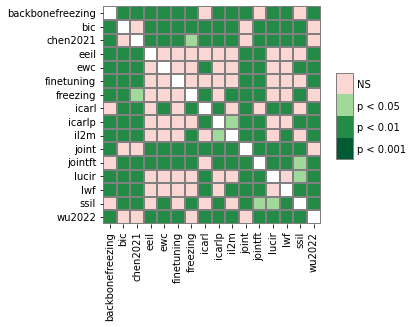

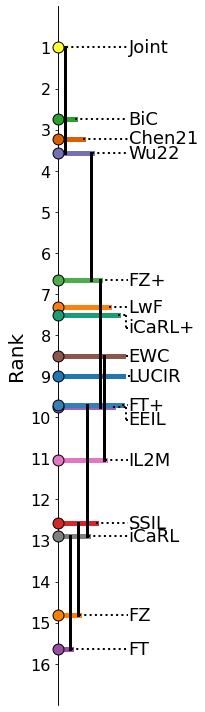

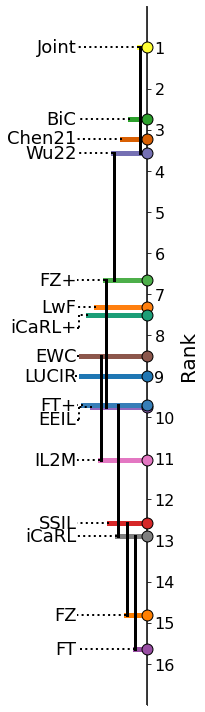

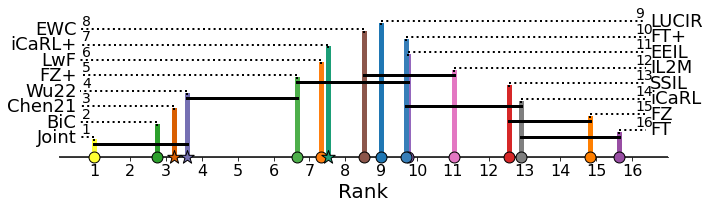

In [39]:
ranking_analysis(df_rank, metrics='all', average=True, savefig='ranking_metrics_all_averaged_both')

## Ranking Analysis by (complementary) F1 Score Average

Elaborating cF1 Score metric...

Methods: 11 Datasets: 50

Should we reject H0 (i.e. is there a difference in the means) at the 95.0 % confidence level? True w/ p=0.0000

Friedman Ranking

bic: 2.56 (1.70)
wu2022: 3.35 (2.22)
chen2021: 4.16 (2.76)
lwf: 5.97 (3.96)
icarlp: 8.95 (5.94)
ewc: 9.89 (6.56)
lucir: 10.40 (6.90)
eeil: 11.22 (7.44)
il2m: 13.09 (8.68)
ssil: 13.63 (9.04)
icarl: 16.28 (10.80)

Nemenyi Scores Heatmap


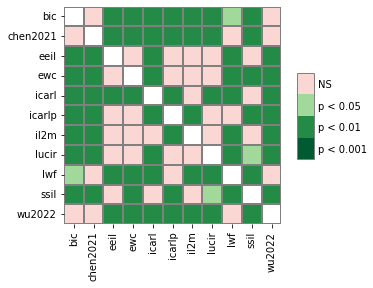

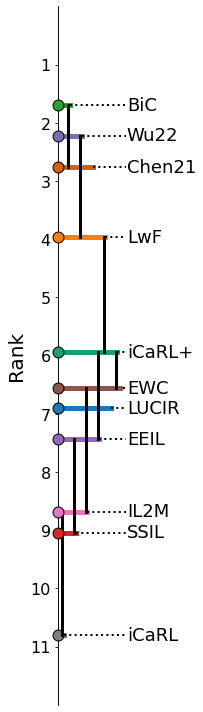

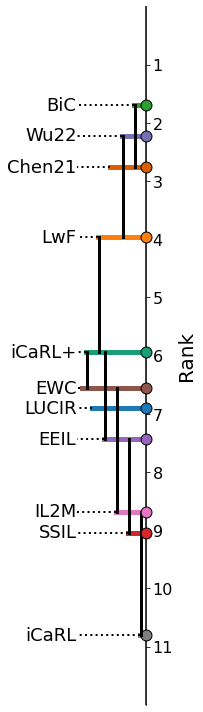

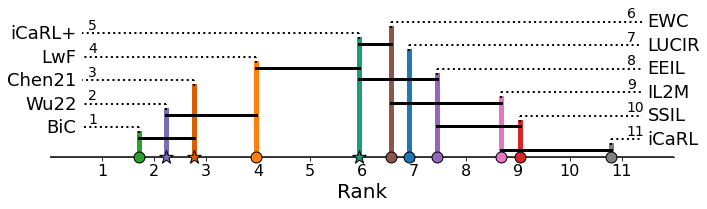

In [14]:
ranking_analysis(df_rank, metrics=['cF1 Score'])

## Ranking Analysis by averaging the Drop Old and Intransigence F1 Score

Elaborating Average btw F1 Score Drop Old, F1 Score Intransigence metrics...

Methods: 11 Datasets: 50

Should we reject H0 (i.e. is there a difference in the means) at the 95.0 % confidence level? True w/ p=0.0000

Friedman Ranking

bic: 3.05 (2.02)
chen2021: 3.14 (2.08)
wu2022: 5.01 (3.32)
icarlp: 7.45 (4.94)
ewc: 8.35 (5.54)
lucir: 9.23 (6.12)
eeil: 10.13 (6.72)
lwf: 11.58 (7.68)
il2m: 11.91 (7.90)
ssil: 14.59 (9.68)
icarl: 15.08 (10.00)

Nemenyi Scores Heatmap


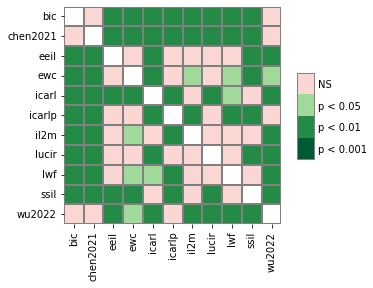

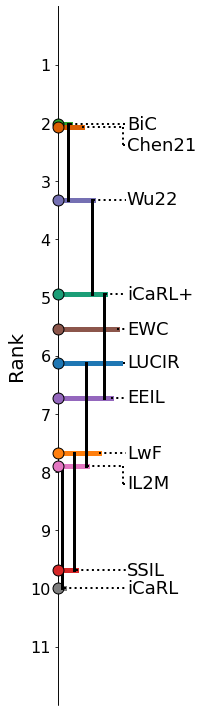

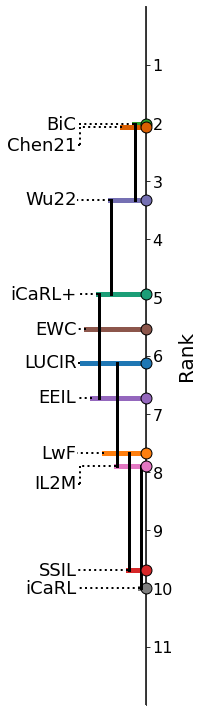

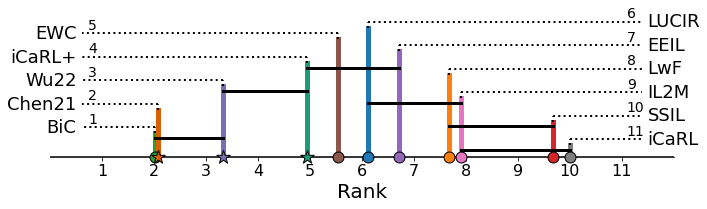

In [15]:
ranking_analysis(df_rank, metrics=['F1 Score Drop Old', 'F1 Score Intransigence'], average=True)

## Ranking Analysis by the Drop Old and Intransigence F1 Score

Elaborating F1 Score Drop Old metric...

Methods: 11 Datasets: 50

Should we reject H0 (i.e. is there a difference in the means) at the 95.0 % confidence level? True w/ p=0.0000

Friedman Ranking

bic: 2.56 (1.70)
wu2022: 3.35 (2.22)
chen2021: 4.16 (2.76)
lwf: 5.97 (3.96)
icarlp: 8.95 (5.94)
ewc: 9.89 (6.56)
lucir: 10.40 (6.90)
eeil: 11.22 (7.44)
il2m: 13.09 (8.68)
ssil: 13.63 (9.04)
icarl: 16.28 (10.80)

Nemenyi Scores Heatmap


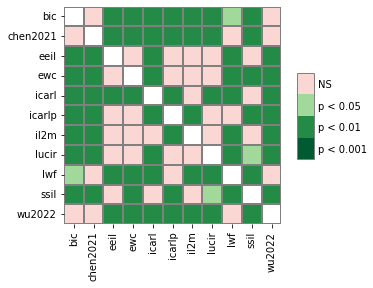

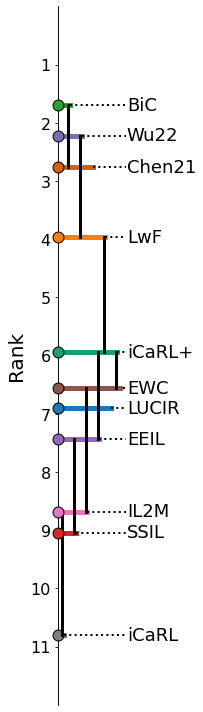

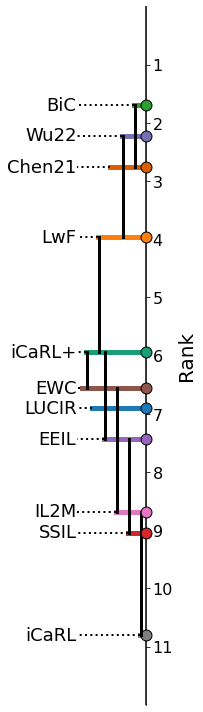

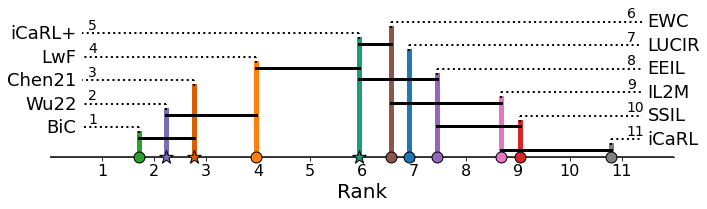

Elaborating F1 Score Intransigence metric...

Methods: 11 Datasets: 50

Should we reject H0 (i.e. is there a difference in the means) at the 95.0 % confidence level? True w/ p=0.0000

Friedman Ranking

chen2021: 4.76 (3.16)
bic: 4.82 (3.20)
wu2022: 7.45 (4.94)
icarlp: 7.96 (5.28)
icarl: 8.41 (5.58)
lucir: 8.47 (5.62)
ewc: 8.71 (5.78)
eeil: 9.71 (6.44)
il2m: 10.61 (7.04)
lwf: 14.08 (9.34)
ssil: 14.50 (9.62)

Nemenyi Scores Heatmap


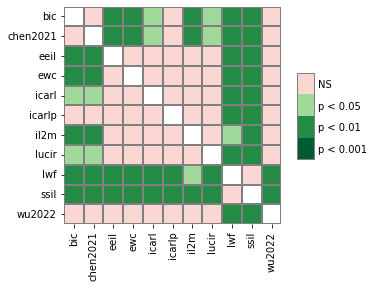

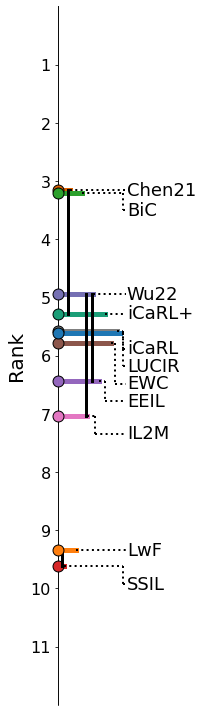

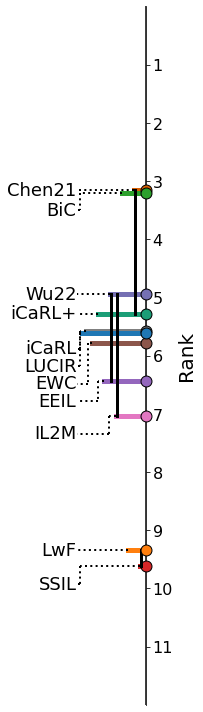

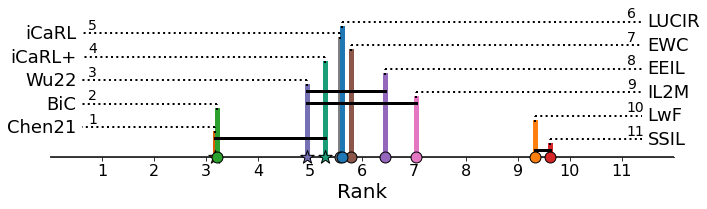

In [16]:
ranking_analysis(df_rank, metrics=['F1 Score Drop Old', 'F1 Score Intransigence'], average=False)

# Comments
- Something strange happen for BiC, which is pushed down to the ranking
- Let we see per-increment (viz. scenario) analysis

# Scenario 39+1

## Ranking Analysis by averaging the 5 metrics

Elaborating Average btw all metrics...

Methods: 11 Datasets: 40

Should we reject H0 (i.e. is there a difference in the means) at the 95.0 % confidence level? True w/ p=0.0000

Friedman Ranking

bic: 1.99 (1.48)
chen2021: 2.36 (1.75)
wu2022: 3.91 (2.90)
icarlp: 6.27 (4.65)
ewc: 7.72 (5.72)
lwf: 8.36 (6.20)
eeil: 9.61 (7.12)
lucir: 10.01 (7.42)
il2m: 11.06 (8.20)
ssil: 13.75 (10.20)
icarl: 13.96 (10.35)

Nemenyi Scores Heatmap


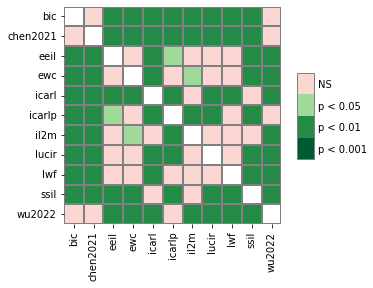

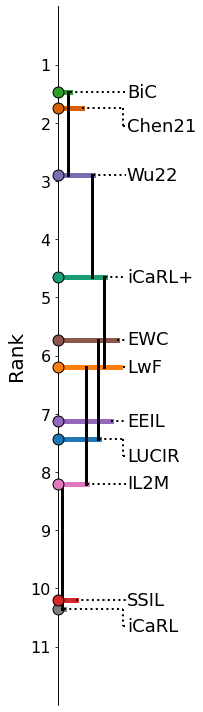

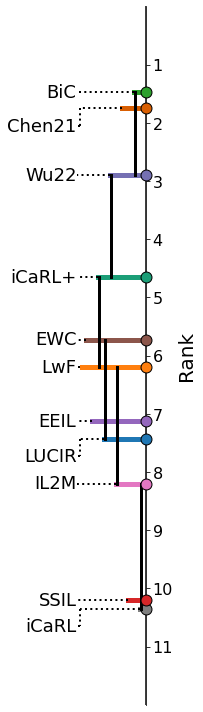

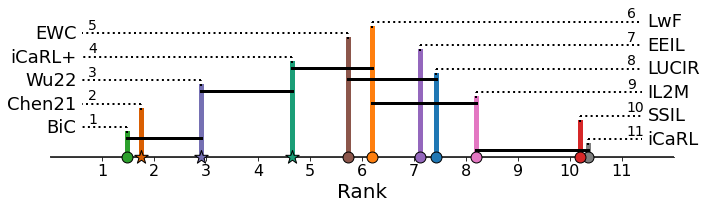

In [17]:
ranking_analysis(df_rank[df_rank['Increment'] == 1], metrics='all', average=True, savefig='ranking_metrics_all_averaged_39_1')

## Ranking Analysis by (complementary) F1 Score Average

Elaborating cF1 Score metric...

Methods: 11 Datasets: 40

Should we reject H0 (i.e. is there a difference in the means) at the 95.0 % confidence level? True w/ p=0.0000

Friedman Ranking

bic: 2.19 (1.62)
wu2022: 3.07 (2.27)
chen2021: 3.88 (2.88)
lwf: 4.65 (3.45)
icarlp: 7.21 (5.35)
ewc: 8.66 (6.42)
eeil: 9.84 (7.30)
lucir: 10.32 (7.65)
il2m: 11.43 (8.47)
ssil: 13.21 (9.80)
icarl: 14.53 (10.78)

Nemenyi Scores Heatmap


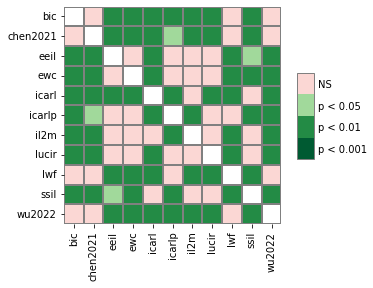

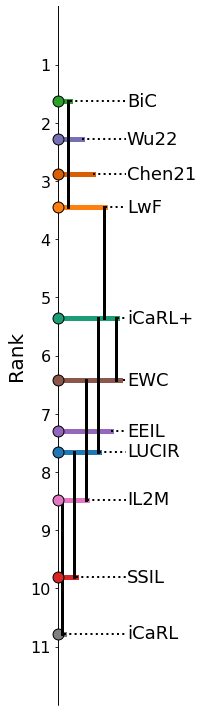

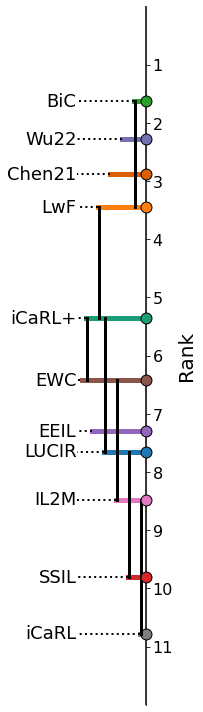

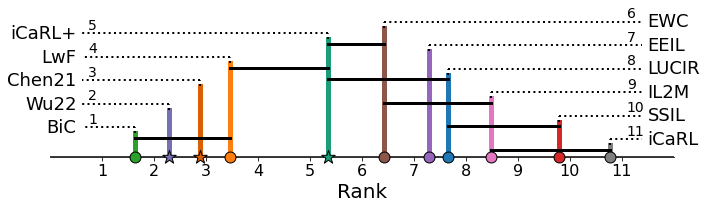

In [18]:
ranking_analysis(df_rank[df_rank['Increment'] == 1], metrics=['cF1 Score'])

## Ranking Analysis by averaging the Drop Old and Intransigence F1 Score

Elaborating Average btw F1 Score Drop Old, F1 Score Intransigence metrics...

Methods: 11 Datasets: 40

Should we reject H0 (i.e. is there a difference in the means) at the 95.0 % confidence level? True w/ p=0.0000

Friedman Ranking

bic: 2.16 (1.60)
chen2021: 2.43 (1.80)
wu2022: 5.19 (3.85)
icarlp: 5.66 (4.20)
ewc: 6.74 (5.00)
eeil: 8.76 (6.50)
lucir: 9.24 (6.85)
il2m: 10.21 (7.58)
lwf: 11.02 (8.18)
icarl: 13.18 (9.78)
ssil: 14.39 (10.68)

Nemenyi Scores Heatmap


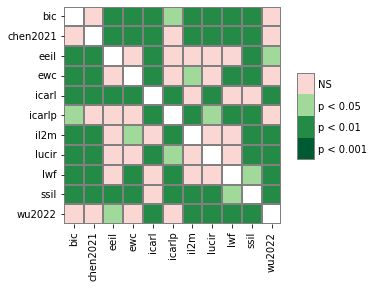

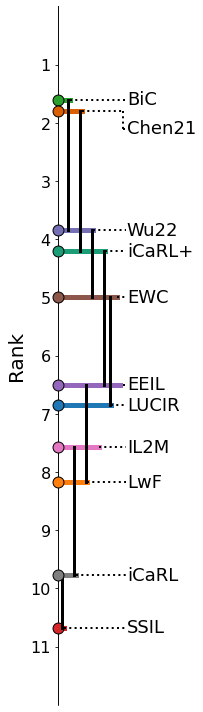

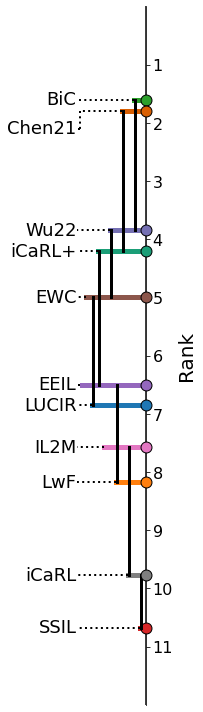

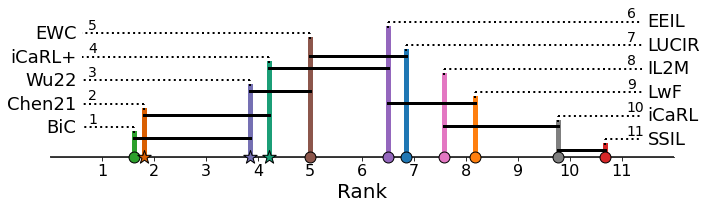

In [19]:
ranking_analysis(df_rank[df_rank['Increment'] == 1], metrics=['F1 Score Drop Old', 'F1 Score Intransigence'], average=True)

## Ranking Analysis by the Drop Old and Intransigence F1 Score

Elaborating F1 Score Drop Old metric...

Methods: 11 Datasets: 40

Should we reject H0 (i.e. is there a difference in the means) at the 95.0 % confidence level? True w/ p=0.0000

Friedman Ranking

bic: 2.19 (1.62)
wu2022: 3.07 (2.27)
chen2021: 3.88 (2.88)
lwf: 4.65 (3.45)
icarlp: 7.21 (5.35)
ewc: 8.66 (6.42)
eeil: 9.84 (7.30)
lucir: 10.32 (7.65)
il2m: 11.43 (8.47)
ssil: 13.21 (9.80)
icarl: 14.53 (10.78)

Nemenyi Scores Heatmap


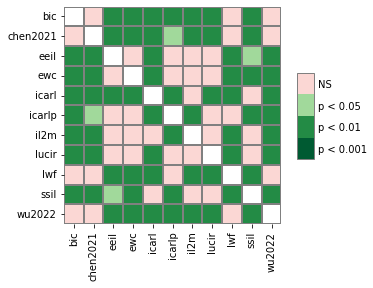

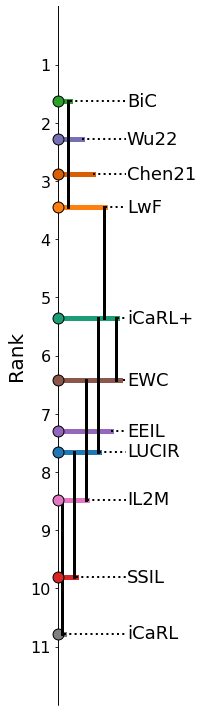

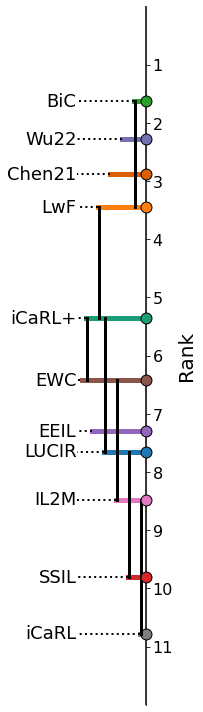

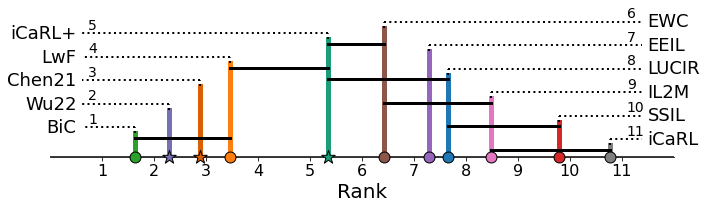

Elaborating F1 Score Intransigence metric...

Methods: 11 Datasets: 40

Should we reject H0 (i.e. is there a difference in the means) at the 95.0 % confidence level? True w/ p=0.0000

Friedman Ranking

chen2021: 2.90 (2.15)
bic: 3.64 (2.70)
icarl: 5.73 (4.25)
icarlp: 6.64 (4.92)
ewc: 6.74 (5.00)
wu2022: 7.96 (5.90)
lucir: 8.66 (6.42)
eeil: 8.80 (6.53)
il2m: 9.61 (7.12)
lwf: 14.16 (10.50)
ssil: 14.16 (10.50)

Nemenyi Scores Heatmap


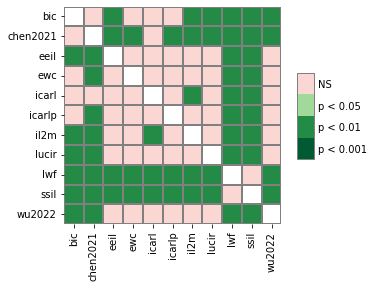

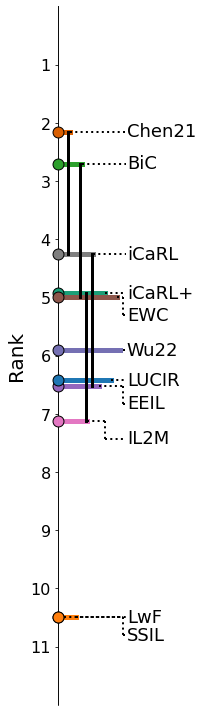

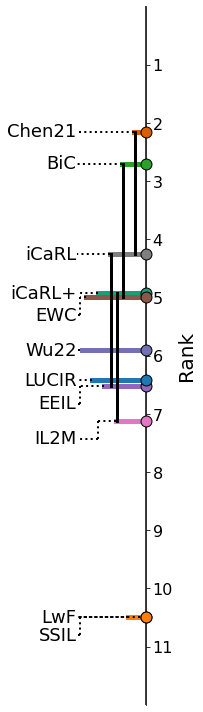

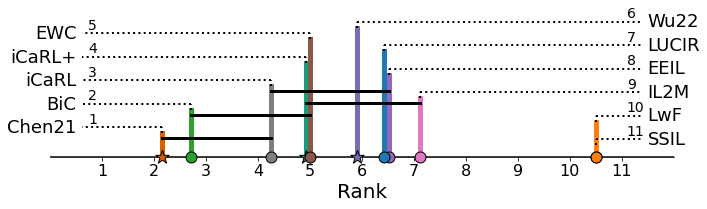

In [20]:
ranking_analysis(df_rank[df_rank['Increment'] == 1], metrics=['F1 Score Drop Old', 'F1 Score Intransigence'], average=False)

# Scenario 20+20

## Ranking Analysis by averaging the 5 metrics

Elaborating Average btw all metrics...

Methods: 11 Datasets: 10

Should we reject H0 (i.e. is there a difference in the means) at the 95.0 % confidence level? True w/ p=0.0000

Friedman Ranking

wu2022: 0.94 (1.40)
bic: 1.89 (2.80)
chen2021: 2.09 (3.10)
lucir: 2.22 (3.30)
lwf: 3.84 (5.70)
ssil: 3.98 (5.90)
ewc: 5.06 (7.50)
eeil: 5.39 (8.00)
icarlp: 5.53 (8.20)
il2m: 6.20 (9.20)
icarl: 7.35 (10.90)

Nemenyi Scores Heatmap


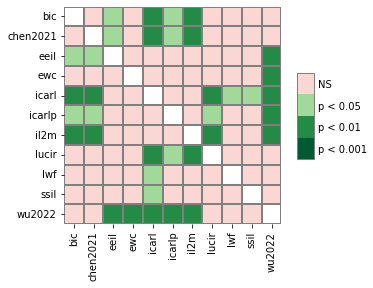

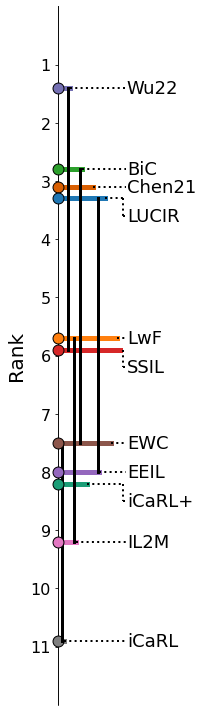

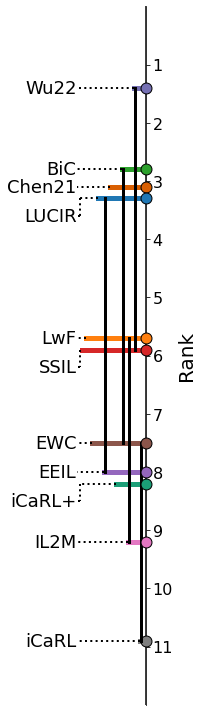

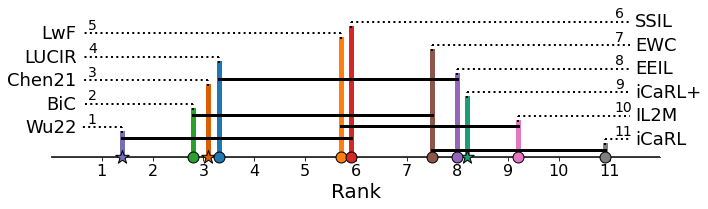

In [21]:
ranking_analysis(df_rank[df_rank['Increment'] == 20], metrics='all', average=True, savefig='ranking_metrics_all_averaged_20_20')

## Ranking Analysis by (complementary) F1 Score Average

Elaborating cF1 Score metric...

Methods: 11 Datasets: 10

Should we reject H0 (i.e. is there a difference in the means) at the 95.0 % confidence level? True w/ p=0.0000

Friedman Ranking

bic: 1.35 (2.00)
wu2022: 1.35 (2.00)
chen2021: 1.55 (2.30)
lucir: 2.63 (3.90)
lwf: 4.05 (6.00)
ssil: 4.05 (6.00)
ewc: 4.79 (7.10)
eeil: 5.39 (8.00)
icarlp: 5.60 (8.30)
il2m: 6.40 (9.50)
icarl: 7.35 (10.90)

Nemenyi Scores Heatmap


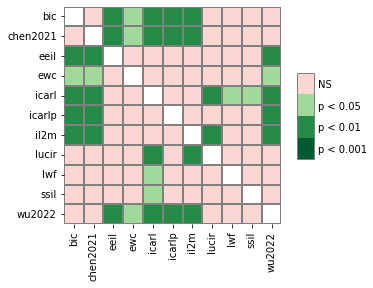

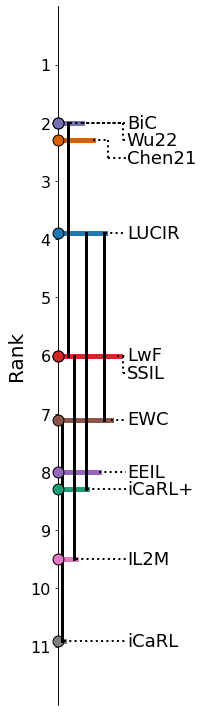

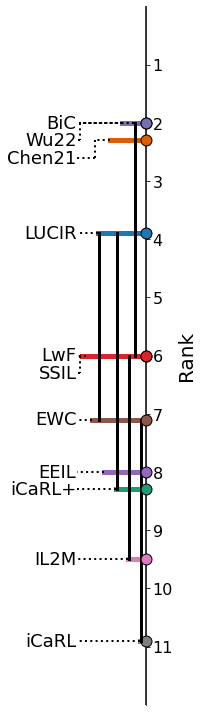

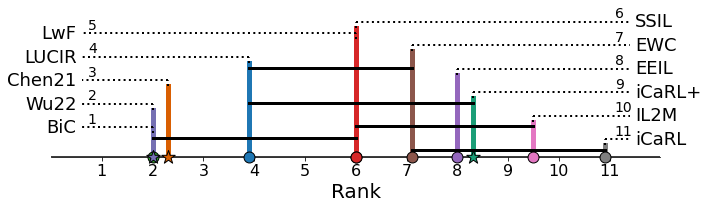

In [22]:
ranking_analysis(df_rank[df_rank['Increment'] == 20], metrics=['cF1 Score'])

## Ranking Analysis by averaging the Drop Old and Intransigence F1 Score

Elaborating Average btw F1 Score Drop Old, F1 Score Intransigence metrics...

Methods: 11 Datasets: 10

Should we reject H0 (i.e. is there a difference in the means) at the 95.0 % confidence level? True w/ p=0.0000

Friedman Ranking

wu2022: 0.81 (1.20)
chen2021: 2.16 (3.20)
lucir: 2.16 (3.20)
bic: 2.49 (3.70)
lwf: 3.84 (5.70)
ssil: 3.84 (5.70)
eeil: 5.12 (7.60)
ewc: 5.19 (7.70)
icarlp: 5.33 (7.90)
il2m: 6.20 (9.20)
icarl: 7.35 (10.90)

Nemenyi Scores Heatmap


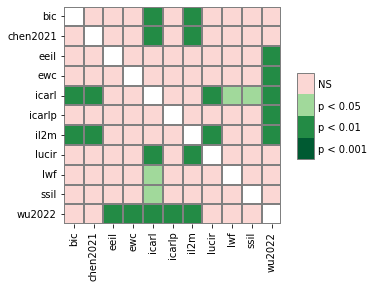

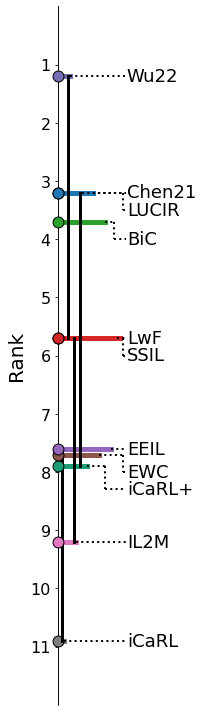

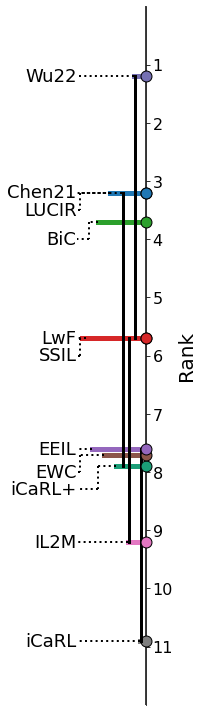

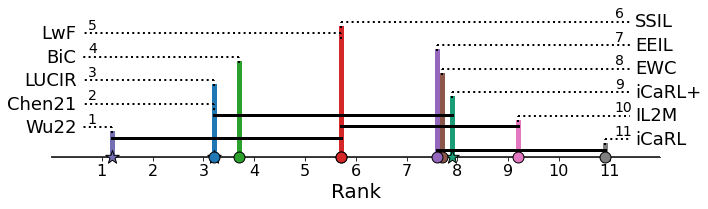

In [23]:
ranking_analysis(df_rank[df_rank['Increment'] == 20], metrics=['F1 Score Drop Old', 'F1 Score Intransigence'], average=True)

## Ranking Analysis by the Drop Old and Intransigence F1 Score

Elaborating F1 Score Drop Old metric...

Methods: 11 Datasets: 10

Should we reject H0 (i.e. is there a difference in the means) at the 95.0 % confidence level? True w/ p=0.0000

Friedman Ranking

bic: 1.35 (2.00)
wu2022: 1.35 (2.00)
chen2021: 1.55 (2.30)
lucir: 2.63 (3.90)
lwf: 4.05 (6.00)
ssil: 4.05 (6.00)
ewc: 4.79 (7.10)
eeil: 5.39 (8.00)
icarlp: 5.60 (8.30)
il2m: 6.40 (9.50)
icarl: 7.35 (10.90)

Nemenyi Scores Heatmap


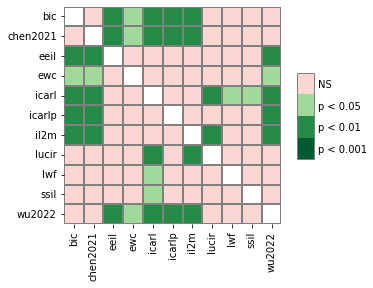

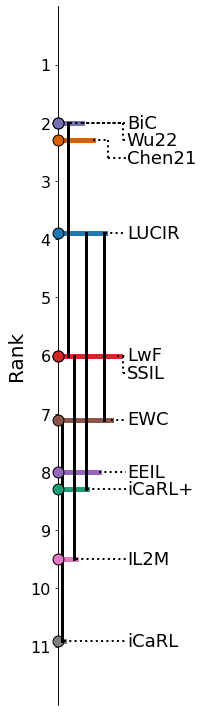

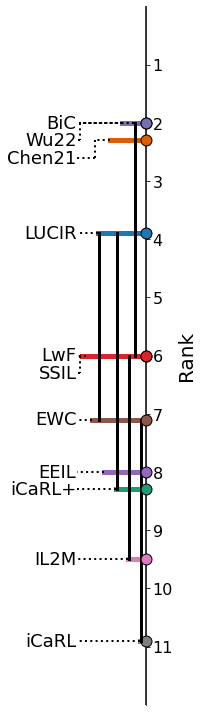

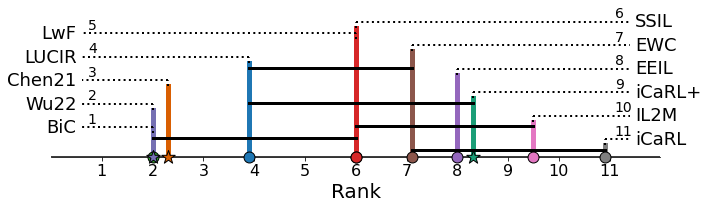

Elaborating F1 Score Intransigence metric...

Methods: 11 Datasets: 10

Should we reject H0 (i.e. is there a difference in the means) at the 95.0 % confidence level? True w/ p=0.0000

Friedman Ranking

wu2022: 0.74 (1.10)
lucir: 1.62 (2.40)
lwf: 3.17 (4.70)
bic: 3.51 (5.20)
eeil: 4.11 (6.10)
ssil: 4.11 (6.10)
icarlp: 4.52 (6.70)
il2m: 4.52 (6.70)
chen2021: 4.85 (7.20)
ewc: 6.00 (8.90)
icarl: 7.35 (10.90)

Nemenyi Scores Heatmap


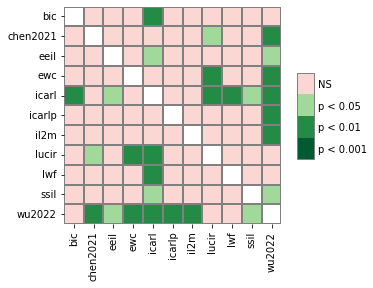

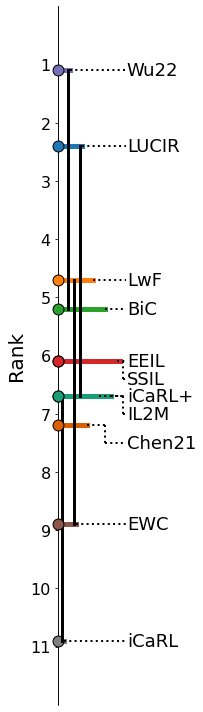

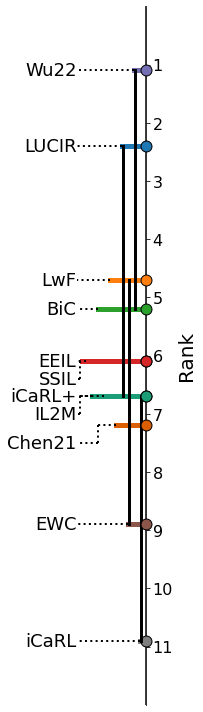

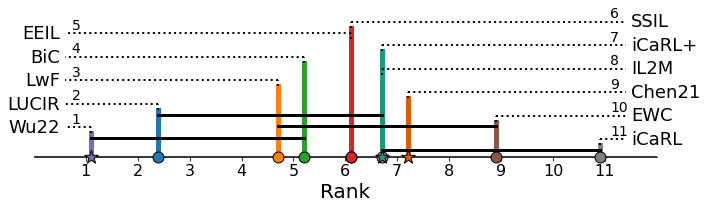

In [24]:
ranking_analysis(df_rank[df_rank['Increment'] == 20], metrics=['F1 Score Drop Old', 'F1 Score Intransigence'], average=False)